# Question4, Uncalibrated
First we do some imports. I am not using some of the packages but may be useful in the future.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import scipy as sp
import pandas as pd
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit, prange
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from dataclasses import dataclass
from typing import Any

Array = Any
Distribution = Any

Model setup: primitives

In [2]:
@dataclass
class Primitives:
    
    epsilon: float #price elasticity
    logabar: float #shift parameter of Markov process
    v: float #markup of fixed cost
    beta: float #discount factor
    tau: float #tariff
    rho: float #persistent parameter of Markov process
    sigma: float #std of Markov process
    xi: float #shipping cost
    f0: float #fixed export cost of starter
    f1: float #fixed export cost of continue
    grid_size: int #grid size of productivity and fixed cost

    def f_probs(self, value, B, v, grid_size): # here I changed Fm(f) to (f/fmv)^(1/(1-v)), otherwise the prob is negative
        prob = np.zeros(grid_size)
        for i in range(len(value) - 1):
            prob[i] = (value[i+1]/B)**(1/(1 - v)) - (value[i]/B)**(1/(1 - v))
        return prob

    def __post_init__(self):
        self.mc = qe.markov.tauchen(
                rho=self.rho, sigma_u=self.sigma, b=self.logabar, m=4, n=self.grid_size
        )
        self.a_vals = np.exp(self.mc.state_values)
        # conditional probabilities
        self.G = self.mc.P
        self.stationary_distribution_a = self.mc.stationary_distributions.flatten()

        self.F0 = np.linspace(0, self.f0*self.v, self.grid_size+1)
        self.F1 = np.linspace(0, self.f1*self.v, self.grid_size+1)
        self.f0_probs = self.f_probs(self.F0, self.f0*self.v, self.v, self.grid_size)
        self.f1_probs = self.f_probs(self.F1, self.f1*self.v, self.v, self.grid_size)
        self.F0 = self.F0[1:]
        self.F1 = self.F1[1:]

Model setup: returns

In [3]:
@dataclass
class Result:
    esp: float # exporter sales premium, here define as mean(pi(exporter)/pi(nonexporter)) with same a_value.
    a_vals: Array #a values
    F0: Array #cost of starters
    F1: Array #cost of continue
    f0_probs: Array #pdf of starters
    f1_probs: Array #pdf of continue
    G: Array #transition matrix of a_vals
    sda: Array #stationary distribution of a
    v0: Array # value function new starter
    v1: Array # value function continuation
    m0: Array # entry decision rule
    m1: Array # continue decision rule
    pi0: Array #revenue of non exporters
    pi1: Array #revenue of exporters
    mei: float # mean export intensity among exporters

Solving model

In [4]:
@dataclass
class Tybout(Primitives):
    tol: float = 1e-6
    max_iter: int = 1e4
    verbose: bool = True
    print_skip: int = 1e3

    def __post_init__(self):
        super().__post_init__()
        self.p0 = np.zeros(self.grid_size)
        self.p1 = np.zeros(self.grid_size)
        self.pi0 = np.zeros(self.grid_size)
        self.pi1 = np.zeros(self.grid_size)
        for i in range(len(self.a_vals)):
            self.p0[i] = self.price(self.a_vals[i], 0)
            self.p1[i] = self.price(self.a_vals[i], 1)
            self.pi0[i] = self.profit(self.a_vals[i], 0, self.p0[i])
            self.pi1[i] = self.profit(self.a_vals[i], 1, self.p1[i])
        self.v0 = np.ones((self.grid_size, self.grid_size))
        self.v1 = np.ones((self.grid_size, self.grid_size))

    def price(self, a, m):
        p = self.epsilon/(a * (self.epsilon - 1))*(1 + (self.tau * self.xi)**(-self.epsilon))/(1 + m * self.xi**(1 - self.epsilon) * self.tau**(-self.epsilon))
        return p

    def profit(self, a, m, p):
        pi = (1 + m * self.xi**(1 - self.epsilon) * self.tau**(-self.epsilon)) * p**(1 - self.epsilon) - 1 / a * (1 + (self.tau * self.xi)**(-self.epsilon)) * p**(-self.epsilon)
        return pi

    def T_value_operator(self, v, F, pi):
        v_new = np.empty_like(v)
        for i in range(len(v)):
            for j in range(len(v)):
                v_new[i, j] = pi[i] + self.beta * max(-F[j] + self.beta * self.G[i, :] @ self.v1 @ self.f1_probs, self.beta * self.G[i, :] @ self.v0 @ self.f0_probs)

        return v_new

    def policy(self, v, F):

        m = np.empty(v.shape)

        for i in range(len(v)):
            for j in range(len(v)):
                v1 = -F[j] + self.G[i, :] @ self.v1 @ self.f1_probs
                v0 = self.G[i, :] @ self.v0 @ self.f0_probs
                if v1 > v0:
                    m[i, j] = 1
                else:
                    m[i, j] = 0
        return m

    def value_func_iteration(self):

        i = 0
        error = self.tol + 1

        while i < self.max_iter and error > self.tol:
            v0_new = self.T_value_operator(self.v0, self.F0, self.pi0)
            v1_new = self.T_value_operator(self.v1, self.F1, self.pi1)
            error = np.max(np.abs(self.v0 - v0_new)) + np.max(np.abs(self.v1 - v1_new))
            if self.verbose and i % self.print_skip == 0:
                print(f"Error at iteration {i} is {error}.")
            self.v0 = v0_new
            self.v1 = v1_new
            i+=1

        if i == self.max_iter:
            print("Failed to converge!")

        if self.verbose and i < self.max_iter:
            print(f"\nConverged in {i} iterations.")

        return self.v0, self.v1


    def solve_model(self):
        super().__post_init__()
        v0, v1 = self.value_func_iteration()
        m0 = self.policy(v0, self.F0)
        m1 = self.policy(v1, self.F1)
        esp = np.mean(self.pi1/self.pi0)
        mei = self.xi**(1 - self.epsilon) * self.tau**(-self.epsilon)/(1 + self.xi**(1 - self.epsilon) * self.tau**(-self.epsilon))

        return Result(
            esp=esp,
            a_vals=self.a_vals,
            F0=self.F0,
            F1=self.F1,
            f0_probs=self.f0_probs,
            f1_probs=self.f1_probs,
            G=self.G,
            sda=self.stationary_distribution_a,
            v0=v0,
            v1=v1,
            m0=m0,
            m1=m1,
            pi0=self.pi0,
            pi1=self.pi1,
            mei=mei
        )

Try it out

In [5]:
test = Tybout(
    epsilon=4,
    logabar=0,
    v=0.2,
    beta=0.9,
    tau=1.1,
    rho=0.9,
    sigma=0.5,
    xi=1.2,
    f0=1000,
    f1=500,
    grid_size=100
)
res = test.solve_model()


Error at iteration 0 is 204424.3923856863.

Converged in 88 iterations.


## Question 1, Calibration
Instead of export participation, I use start_rate and stop_rate, exporter sales premium, mean export intensity to calibrate the model.

In [6]:
start_rate = res.sda @ res.m0 @ res.f0_probs
start_rate
stop_rate = 1 - res.sda @ res.m1 @ res.f1_probs
stop_rate
res.esp
res.mei

0.04983358249059988

0.9234031311335439

3.7898636359997506

0.2832889438444258

## Question 2, graph

[Text(0, 0.5, 'F0'), Text(0.5, 0, 'a_vals')]

Text(40, 10, 'export')

Text(0, 150, 'do not export')

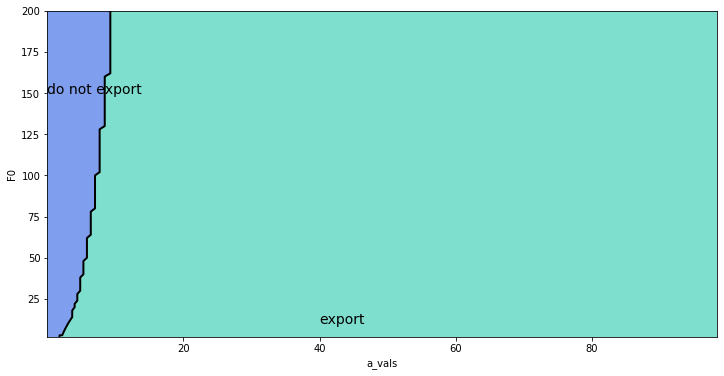

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
tg, eg = np.meshgrid(res.a_vals, res.F0)
lvls = (-0.5, 0.5, 1.5)
ax.contourf(tg, eg, res.m0.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, res.m0.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='a_vals', ylabel='F0')
ax.text(40, 10, 'export', fontsize=14)
ax.text(0, 150, 'do not export', fontsize=14)
plt.show()

## Question 3, graph

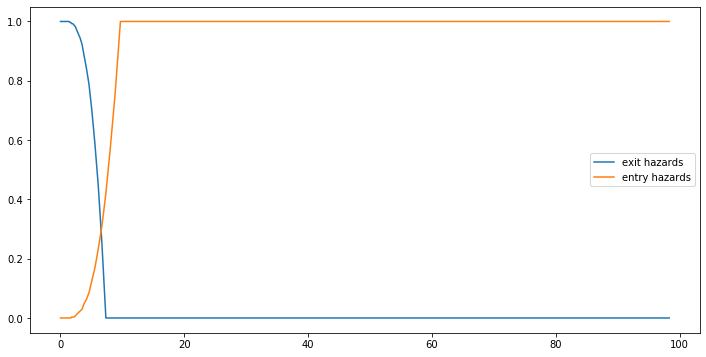

In [8]:
exit_hazards = 1 - res.m1 @ res.f1_probs

entry_hazards = res.m0 @ res.f0_probs

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(res.a_vals, exit_hazards, label='exit hazards')
ax.plot(res.a_vals, entry_hazards, label='entry hazards')
ax.legend()
plt.show()

## Question 4
The relationship is $starter\ rate*(1 - export\ participation\ rate) = stopper\ rate*export\ participation\ rate$.

## Question 5